<a href="https://colab.research.google.com/github/nobertomaciel/megasena/blob/main/megasena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
!pip install deap update_checker tqdm stopit xgboost
!pip install scikit-mdr skrebate

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import urllib.request
import time
import datetime
from google.colab import files
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, make_scorer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import distance
from yellowbrick.cluster import KElbowVisualizer
from unicodedata import normalize

In [3]:
csv_file = ["https://raw.githubusercontent.com/nobertomaciel/megasena/main/megasena.csv"]

In [4]:
df = pd.DataFrame()
for n in csv_file:
    print("Reading...",n)
    r = pd.read_csv(n, 
                    sep=';', 
                    index_col=False,
                    header=0,
                    encoding='latin-1', 
                    decimal=",",
                    )
    df = df.append(r).dropna()

Reading... https://raw.githubusercontent.com/nobertomaciel/megasena/main/megasena.csv


In [ ]:
display(df.head(5))
display(df.nunique())
display(df.dtypes)

In [21]:
# check if dozens exists
def checkDozens(dozensToCheck):
  c = 0
  dozensToCheck.sort()
  for i in df.index:
    if(int(df["Dezena1"][i])==dozensToCheck[0] and int(df["Dezena2"][i])==dozensToCheck[1] and int(df["Dezena3"][i])==dozensToCheck[2] and int(df["Dezena4"][i])==dozensToCheck[3] and int(df["Dezena5"][i])==dozensToCheck[4] and int(df["Dezena6"][i])==dozensToCheck[5]):
        print("Localizado: ",dozensToCheck)
        c += 1
  return "Encontrados: "+str(c)

In [23]:
# insert dozens here: check if dozens exists
print(checkDozens([3,7,22,33,41,42]))

Encontrados: 0


In [ ]:
#feature1 é a soma ponderada das dos algarismos das dezenas com pesos de 1 a 6 de acordo com a posição ocupada pela dezena no jogo  
#Exemplo para o jogo: 12 14 22 35 43 51
#                     51 (6a dezena) (5+1)*6 = 36
#                     14 (2a dezena) (1+4)*2 = 10
def feature1():
  df["feature1"] = df["Dezena1"].apply(lambda x: x**1 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**1)
  df["feature1"] += df["Dezena2"].apply(lambda x: x**2 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**2)
  df["feature1"] += df["Dezena3"].apply(lambda x: x**3 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**3)
  df["feature1"] += df["Dezena4"].apply(lambda x: x**4 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**4)
  df["feature1"] += df["Dezena5"].apply(lambda x: x**5 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**5)
  df["feature1"] += df["Dezena6"].apply(lambda x: x**6 if(x < 9) else (int(str(x)[:1])+int(str(x)[-1:]))**6)
  display(df.head(1))
  display(df.nunique())

feature1()

In [ ]:
#feature2 é a soma SIMPLES dos algarismos das dezenas do jogo (Ex.: 12 => 1+2 = 3)
def feature2():
  df["feature2"] = df["Dezena1"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  df["feature2"] += df["Dezena2"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  df["feature2"] += df["Dezena3"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  df["feature2"] += df["Dezena4"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  df["feature2"] += df["Dezena5"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  df["feature2"] += df["Dezena6"].apply(lambda x: x if(x < 9) else int(str(x)[:1])+int(str(x)[-1:]))
  display(df.head(1))
  display(df.nunique())

feature2()

In [ ]:
#feature3 é a soma de todos as dezenas do respectivo jogo
def feature3():
  df["feature3"] = df["Dezena1"] + df["Dezena2"] + df["Dezena3"] + df["Dezena4"] + df["Dezena5"] + df["Dezena6"]
  display(df.head(1))
  display(df.nunique())

feature3()

In [ ]:
eixoY = "Dezena1"
eixoX = "feature2"
#Y = df[["feature1","feature2"]].to_numpy()
#Y = df[["feature1","feature3"]].to_numpy()
#Y = df[["feature2","feature3"]].to_numpy() # bom para análise
#Y = df[["feature1","feature2","feature3"]].to_numpy()
#Y = df[["Concurso","feature1"]].to_numpy()
#Y = df[["Concurso","feature2"]].to_numpy()
#Y = df[["Concurso","feature3"]].to_numpy()
Y = df[[eixoY,eixoX]].to_numpy()
print(Y)
print(Y[0])
print(distance.euclidean(Y[0], Y[1]))
print(Y.size, Y.ndim, int((Y.size)/10), int((Y.size/Y.ndim)/10))

# Generating the sample data from make_blobs
X, y = make_blobs(
    n_samples=int((Y.size)/10),
    n_features=3,
    centers=6,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)

print(X.size, X.ndim)
print(y.size, y.ndim)

X = Y

In [33]:
# determine number of the clusters scheme
#range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12]
#range_n_clusters = [6]
range_n_clusters = [4,5,6]

# to plot silhouette average
silhouette_avg_plot = []

# to plot risc curve
risk_plot = []

In [34]:
# similarity euclidean distance
def euclidean_distance(xi,xj):
  return np.sqrt(sum(pow(a-b,2) for a, b in zip(xi, xj)))

# normalizar
def normalize(X):
    n = np.linalg.norm(X)
    return X/n

# média das similaridades (val)
def dtrs_val(X):
    sim = []
    # xnorm = normalize(X)
    xnorm = X
    for xi in xnorm:
        for i in range(len(xnorm)):
          xj = xnorm[i]
          sim.append(euclidean_distance(xi,xj))
    # sim = normalize(sim)
    return (1/(len(xnorm)^2))*sum(sim)

# custom loss function
def dtrs_risk(X,y):
    risk = []
    val = dtrs_val(X)
    # xnorm = normalize(X)
    xnorm = X
    for i in range(len(xnorm)):
        xi = xnorm[i]
        for j in range(len(xnorm)):
            xj = xnorm[j]
            sim = euclidean_distance(xi,xj)
            if sim >= val and y[i] == y[j]:
                risk.append(0.5-((sim-val)/(2-2*val)))
            elif sim < val and y[i] == y[j]:
                risk.append(0.5+((val-sim)/(2*val)))
            elif sim >= val and y[i] != y[j]:
                risk.append(0.5+((sim-val)/(2-2*val)))
            elif sim < val and y[i] != y[j]:
                risk.append(0.5-((val-sim)/(2*val)))
    return sum(normalize(risk))

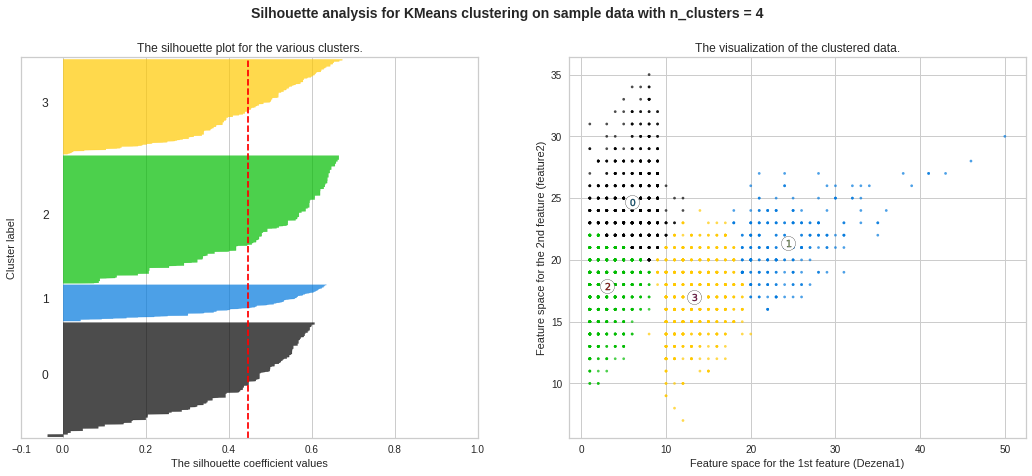

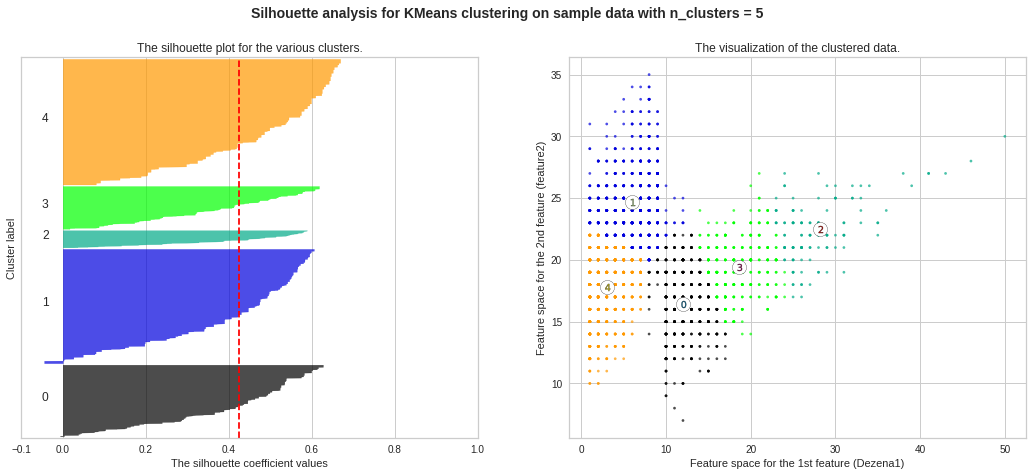

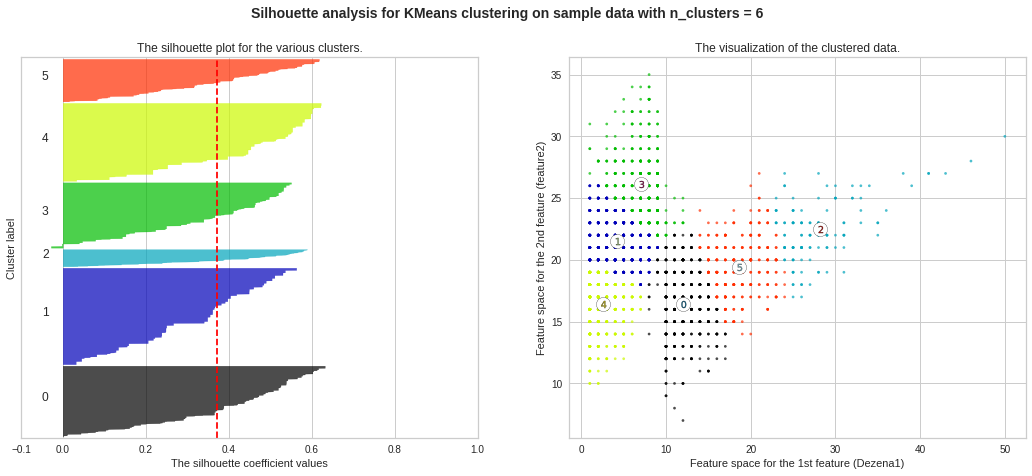

In [35]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_plot.append(silhouette_avg)    

    # Compute DTRS (custom score function)
    risk = dtrs_risk(X,cluster_labels)
    risk_plot.append(risk)

    # print results
      # print(
      #     "\n----------------------------------------------------------------------\n",
      #     "\n For n_clusters: ", n_clusters,
      #     "\n The average silhouette_score is: ", silhouette_avg,
      #     # "\n X:\n",
      #     # X,
      #     # "\n len X: ", len(X),
      #     # "\n X shape (elements, features):", X.shape,
      #     # "\n y:\n",
      #     # y,
      #     "\n Cluster labels:\n",
      #     cluster_labels,
      #     "\n Risk: ",
      #     risk,
      #     "\n----------------------------------------------------------------------\n",
      # )
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature ("+feature1+")")
    # ax2.set_ylabel("Feature space for the 2nd feature ("+feature2+")")
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    # fim
    plt.suptitle(
        "Silhouette analysis for clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature ("+eixoY+")")
    ax2.set_ylabel("Feature space for the 2nd feature ("+eixoX+")")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

In [36]:
cluster = 5
df["cluster_labels"] = pd.DataFrame(cluster_labels, columns = ['cluster_labels'])
print(len(df.loc[df['cluster_labels'] == cluster]))
print(df[eixoX].loc[df['cluster_labels'] == cluster].describe())
df.loc[df['cluster_labels'] == cluster].head(5)

269
count    269.000000
mean      19.743494
std        3.959356
min       10.000000
25%       17.000000
50%       19.000000
75%       22.000000
max       34.000000
Name: feature2, dtype: float64


,Concurso,Dezena1,Dezena2,Dezena3,Dezena4,Dezena5,Dezena6,feature1,feature2,feature3,cluster_labels
10,10.0,4.0,18.0,21.0,25.0,38.0,57.0,15897.0,17.0,163.0,5.0
12,12.0,4.0,16.0,19.0,20.0,27.0,43.0,4150.0,14.0,129.0,5.0
15,15.0,12.0,33.0,35.0,51.0,52.0,60.0,50443.0,23.0,243.0,5.0
17,17.0,6.0,10.0,13.0,19.0,20.0,51.0,15666.0,16.0,119.0,5.0
22,22.0,1.0,9.0,31.0,38.0,46.0,56.0,16839.0,25.0,181.0,5.0


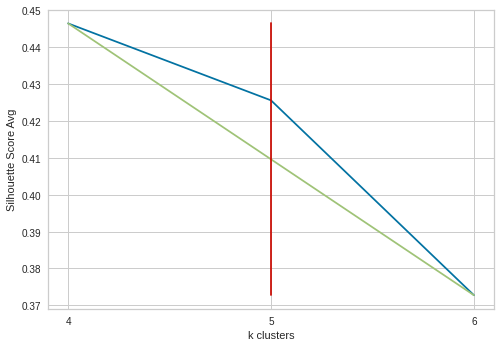

0.0


In [37]:
# plot silhouette average curve
fig = plt.figure()
ax = plt.axes()
x = range_n_clusters
y = silhouette_avg_plot
ax.plot(x, y);
ax.set_ylabel('Silhouette Score Avg')
ax.set_xlabel('k clusters')
ax.set_xticks(x)
rx = np.linspace(x[0],x[len(x)-1],len(x))
ry = np.linspace(y[0],y[len(y)-1],len(y))
ax.plot(rx, ry, '-g');
r = np.array(ry-y)
abs = [n*(-1) if n<0 else n for n in r]
pointElbow = np.full((len(ry)), rx[list(abs).index(max(abs))], dtype=int)
ax.plot(pointElbow, ry, '-r');
plt.show()
print(max(ry-y))

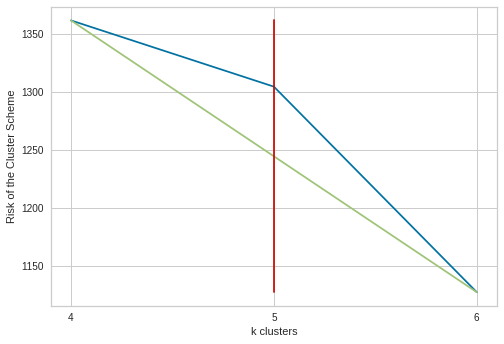

0.0


In [38]:
# plot risk curve
fig = plt.figure()
ax = plt.axes()
x = range_n_clusters
y = risk_plot
ax.plot(x, y);
ax.set_ylabel('Risk of the Cluster Scheme')
ax.set_xlabel('k clusters')
ax.set_xticks(x)
rx = np.linspace(x[0],x[len(x)-1],len(x))
ry = np.linspace(y[0],y[len(y)-1],len(y))
ax.plot(rx, ry, '-g');
r = np.array(ry-y)
abs = [n*(-1) if n<0 else n for n in r]
pointElbow = np.full((len(ry)), rx[list(abs).index(max(abs))], dtype=int)
ax.plot(pointElbow, ry, '-r');
plt.show()
print(max(ry-y))

/usr/local/lib/python3.8/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


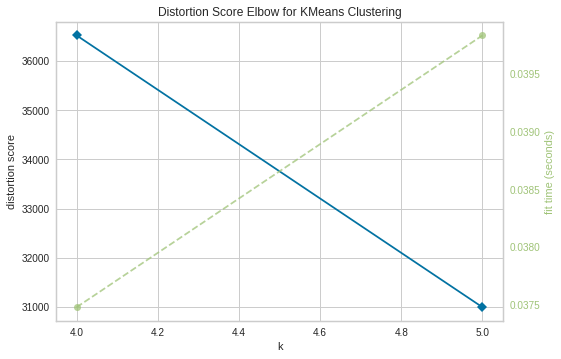

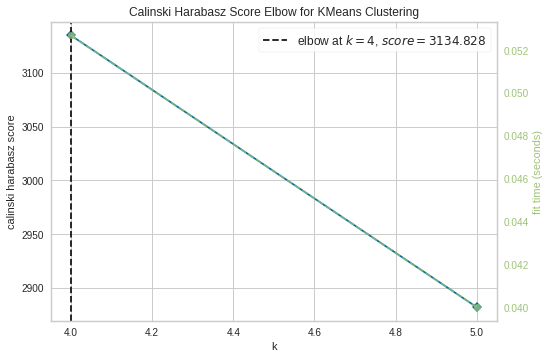

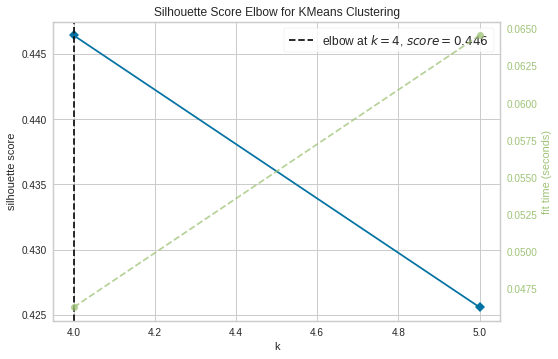

In [39]:
# Elbow Method Algorithm
visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]))
visualizer.fit(X)
visualizer.show()

visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]), metric='calinski_harabasz')
visualizer.fit(X)
visualizer.show()

visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]), metric='silhouette')
visualizer.fit(X)
visualizer.show()